<a href="https://colab.research.google.com/github/Rohit-Roby/Project/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install objaverse
!pip install trimesh
!pip install open3d

  Using cached open3d-0.18.0-cp310-cp310-manylinux_2_27_x86_64.whl (399.7 MB)
  Using cached dash-2.16.1-py3-none-any.whl (10.2 MB)
  Using cached ipywidgets-8.1.2-py3-none-any.whl (139 kB)
  Using cached flask-3.0.3-py3-none-any.whl (101 kB)
  Using cached blinker-1.8.0-py3-none-any.whl (9.3 kB)
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


/usr/lib/python3/dist-packages
rm -r blinker
rm -r /usr/lib/python3/dist-packages

In [4]:
# Import libraries
import objaverse
import nltk
from nltk.corpus import stopwords  # for stop word removal
from nltk.stem import PorterStemmer  # for stemming (or use WordNetLemmatizer for lemmatization)
import string
import trimesh
import os
import shutil
import multiprocessing
nltk.download('stopwords')
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import torch

**Loading the dataset files and dowloading 3d model**

In [6]:
#loading Uids
uids = objaverse.load_uids()
len(uids), type(uids)

# lvis_annotations
lvis_annotations = objaverse.load_lvis_annotations()

# Sort the dictionary by value in descending order and select the top 20 items
top_20_items = dict(sorted(lvis_annotations.items(), key=lambda item: len(item[1]), reverse=True)[:20])
top_20_items.keys()

dict_keys(['chair', 'seashell', 'antenna', 'shield', 'snowman', 'chandelier', 'gravestone', 'cone', 'control', 'sword', 'armor', 'doughnut', 'banana', 'ring', 'fireplug', 'mushroom', 'fighter_jet', 'figurine', 'monitor_(computer_equipment) computer_monitor', 'mug'])

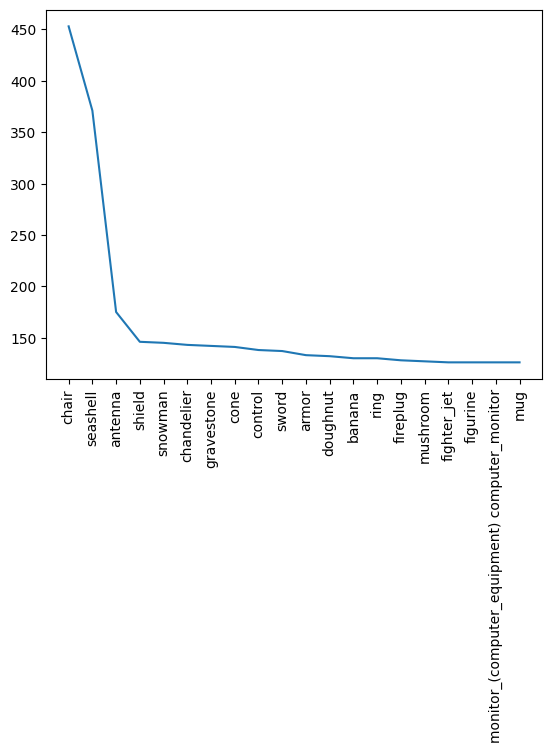

In [7]:

# Plot the keys against the lengths of the values
plt.xticks(rotation='vertical')
plt.plot(list(top_20_items.keys()), [len(value) for value in top_20_items.values()])
plt.show()


In [8]:
# Load Objaverse annotations
top_20_uids = []  # Initialize an empty list
for uid_list in top_20_items.values():
    top_20_uids.extend(uid_list)  # Add UIDs individually


In [9]:
annotations = objaverse.load_annotations(top_20_uids)

 99%|█████████▉| 159/160 [01:29<00:00,  1.77it/s]


In [10]:
# objaverse_description = []
for annotation in annotations.values():
    if isinstance(annotation, dict):
        tags = annotation.get("tags")  # No default value, get returns 'None' if key is missing
        if tags:  # Check if tags exists
            tag_descriptions = [tag['name'] for tag in tags]
            # ... (Rest of your code)
            description = " ".join(tag_descriptions)
             # Store tags and description with annotation
            annotation["description"] = description  # adding a description field
            # objaverse_description.append(description)

In [11]:
import pandas as pd
df = pd.DataFrame()
df['uids'] = top_20_uids
# df['face_count'] = annotations[df['uids']]['archives']['glb']['faceCount']
df['face_count'] = df['uids'].map(lambda x: annotations[x]['archives']['glb']['faceCount'] if x in annotations else None)
df['vertex_count'] = df['uids'].map(lambda x: annotations[x]['archives']['glb']['vertexCount'] if x in annotations else None)
df['texture_count'] = df['uids'].map(lambda x: annotations[x]['archives']['glb']['textureCount'] if x in annotations else None)
df['textureMaxResolution'] = df['uids'].map(lambda x: annotations[x]['archives']['glb']['textureMaxResolution'] if x in annotations else None)


In [12]:
# processes = multiprocessing.cpu_count()
# processes
# objects = objaverse.load_objects(
#     uids = df['uids'],
#     download_processes = processes
# )

In [13]:
# # Define the subfolder and parent folder paths
# parent_dir = '/root/.objaverse/hf-objaverse-v1/glbs'

# # Walk through the parent directory
# for subdir, dirs, files in os.walk(parent_dir):
#     for file in files:
#         # Construct the file path
#         file_path = os.path.join(subdir, file)
#         # Construct the destination path
#         dest_path = os.path.join(parent_dir, file)
#         # Move the file to the parent directory
#         shutil.move(file_path, dest_path)
#     # If the current directory is not the parent directory, delete the subdirectory
#     if subdir != parent_dir:
#         os.rmdir(subdir)
# df['glb_path'] = df['uids'].map(lambda x: objects[x])

**Preprocessing of Text Description**

In [14]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
def clean_description(description):
    # Define stop words
    stop_words = set(stopwords.words("english"))

    # # Clean text descriptions
    # cleaned_descriptions = []
    # for description in description:
    # Remove punctuation
    text = description.translate(str.maketrans('', '', string.punctuation))

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lowercase conversion
    text = text.lower()

    # Stemming (or lemmatization)
    stemmer = PorterStemmer()  # You can replace this with WordNetLemmatizer for lemmatization
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text
    # Add cleaned text to list
  #   cleaned_descriptions.append(text)
  #   annotations['description']
  # # Save cleaned descriptions for further processing
  # with open("cleaned_descriptions.txt", 'w') as f:
  #   f.write('\n'.join(cleaned_descriptions))

    # print("Data collection and cleaning complete!")


df['description'] = df['uids'].map(lambda uid: clean_description( annotations[uid]['description']))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [15]:
import numpy as np
df['description'].replace('', np.nan, inplace=True)
df = df.dropna()

In [16]:
df.to_csv('/root/.objaverse/Dataset')

In [17]:
df['uids'].shape

(2677,)

In [18]:
processes = multiprocessing.cpu_count()
processes
objects = objaverse.load_objects(
    uids = df['uids'],
    download_processes = processes
)

starting download of 2677 objects with 96 processes
Downloaded Downloaded1  /2  2677/  objects2677
 objects
Downloaded 3 / 2677 objects
Downloaded Downloaded5  /6Downloaded  2677 / 7 objectsDownloaded 2677Downloaded
Downloaded/   objects  Downloaded267710
1010 Downloaded    objects///
12 Downloaded    Downloaded267712Downloaded2677Downloaded2677/      Downloaded 6objects/ objects 2677objects15
  15 
Downloaded 15
 2677/ 16objects   / / 
DownloadedDownloadedobjects/ / 267717
   26772677   2677 2677objects 19/19 objectsDownloaded objects 
 
objects 
Downloadedobjects2677 /
/DownloadedDownloaded 
Downloaded 22  objectsDownloaded 2677Downloaded  23
2677 Downloaded26Downloaded  DownloadedDownloaded/26  Downloaded26 DownloadedDownloadedDownloaded objects33Downloaded   / DownloadedDownloaded 35  objects/
  2677 Downloaded35  35 / Downloaded3635  /
  Downloaded36/ 36 26773637   37 / 38  267738 objects  /   2677  /40 // 267740 2677 /
/objects /22/  2677/   / objects /  
  2677  2677objects  267

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 
Downloaded/ DownloadedDownloaded 393   2677Downloaded393Downloaded /393   Downloadedobjects  394/394 2677
 /394   / / objects2677 / 2677 
2677 2677 objects 2677 DownloadedobjectsDownloadedobjects
objects 
  

objects396396
Downloaded  //  397 26772677 Downloaded   /objectsobjects
398 
 2677/  objects
2677 objects
Downloaded 400 DownloadedDownloaded/ Downloaded  Downloaded 4022677403 403   403 //objects Downloaded/  
  2677/2677Downloaded2677 405   objects 2677 405objects
objects / 

DownloadedDownloadedobjects /  2677
 Downloaded408407 2677    objects//409objects 
Downloaded  2677
 2677/   409objectsobjects2677
 
Downloaded / objects 410
 2677/  Downloadedobjects2677 
 411objects 
/ 2677Downloaded  Downloadedobjects414 
 414Downloaded/ Downloaded  2677/415   Downloaded 416Downloadedobjects2677  / 
 Downloaded418/ 418Downloadedobjects   2677 Downloaded
Downloaded/  2677419/   419Downloadedobjects   4212677422 
 objects2677/   /422
 /objects /  objects Downloaded
 26772677/
Downloaded2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Downloaded/  2677791 Downloaded objects/ 
791  2677/  objects2677
 objects
Downloaded 793 /Downloaded  2677793  /objects 
2677Downloaded  objects794
Downloaded  795Downloaded/   /7962677  2677 / objects 2677objects

 objects
Downloaded DownloadedDownloaded801   801801/  Downloaded //  2677 Downloaded8022677 Downloaded2677   objects  Downloaded/802objectsobjects
803   

803 /2677/    /2677objects2677  
 objects2677objectsDownloaded
 
 objects804
 / 2677 objects
Downloaded 805 / 2677 objects
DownloadedDownloadedDownloaded   Downloaded811 811811DownloadedDownloaded   811  // /811 811 /  26772677  2677/  /2677  objectsobjects Downloaded objects
2677
objects 2677Downloaded 

813 objects  813
objectsDownloaded/
   /8152677Downloaded    2677/objects815  
 2677objects/ 
 objects2677
 objects
Downloaded Downloaded817  817/  /2677  objects2677
 DownloadedobjectsDownloaded 
 819 819/  /2677  2677objectsDownloaded  
820objects 
/ 2677 objects
Downloaded 821 / Downloaded2677  822objects 
/ 2677 ob

In [19]:
# Define the subfolder and parent folder paths
parent_dir = '/root/.objaverse/hf-objaverse-v1/glbs'

# Walk through the parent directory
for subdir, dirs, files in os.walk(parent_dir):
    for file in files:
        # Construct the file path
        file_path = os.path.join(subdir, file)
        # Construct the destination path
        dest_path = os.path.join(parent_dir, file)
        # Move the file to the parent directory
        shutil.move(file_path, dest_path)
    # If the current directory is not the parent directory, delete the subdirectory
    if subdir != parent_dir:
        os.rmdir(subdir)
df['glb_path'] = df['uids'].map(lambda x: objects[x])

In [20]:
import re
# Function to remove "/glbs"
def remove_glbs(path):
    return re.sub(r'\d{3}-\d{3}/', '', path)    # Replace '/glbs' with an empty string

# Apply the function using map
df['glb_path'] = df['glb_path'].map(remove_glbs)

**Preprocessing of 3d model into point cloud**

In [21]:
import os
def get_model_paths(base_dir):
    model_paths = []
    for subdir, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".glb"):
                file_path = os.path.join(subdir, file)
                model_paths.append(file_path)
    return model_paths
base_dir ='/root/.objaverse/hf-objaverse-v1/glbs'
model_paths = get_model_paths(base_dir)

In [22]:
# from mpl_toolkits.mplot3d import Axes3D

# glbs = model_paths[0:5]
# # m = trimesh.load(glb, force='mesh')

# # vertices = m.vertices
# # # points = trimesh.points.PointCloud(vertices, colors=colors)
# # points = trimesh.points.PointCloud(vertices)
# # p = vertices.shape[0]
# # colors = np.random.randint(low=0, high=25, size=(p, 3))  # Random colors
# # # Plot the points using matplotlib
# # fig = plt.figure(figsize=(25, 16))
# # ax = fig.add_subplot(111,projection='3d')
# # ax.scatter(  points[:, 2],points[:, 0],points[:, 1], c=colors / 255.0)
# # # ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=)
# # plt.show()
# # Create a figure and axes for the subplots
# fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# # Loop through each subplot and display the mesh
# for i, ax in enumerate(axs.flat):
#     # Plot mesh in each subplot
#     for glb in glbs:
#       if glb:
#           mesh = o3d.io.read_triangle_mesh(glb)
#           ax = o3d.visualization.draw_plotly([mesh])
#     # if i < len(glbs):
#     #     ax = o3d.visualization.draw_geometries_with_plotly([mesh], width=500, height=500, inline=False, use_as_tempfile=True, show=False, gui=True)
#       else:
#           # Hide empty subplots
#           ax.axis('off')
# plt.show()
# # mesh = o3d.io.read_triangle_mesh(glb)
# # o3d.visualization.draw_plotly([mesh])

In [23]:
!pip install pygltflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 746.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.7 MB/s eta 0:00:00
  Created wheel for pygltflib: filename=pygltflib-1.16.2-py3-none-any.whl size=27300 sha256=ae099b84813feabe3eca681d2a62d22744437ef9d3116d7408f93a17e6c6e937
  Stored in directory: /root/.cache/pip/wheels/4a/95/a2/2ee16c602170b0601ebeddbf06597868f09b7dbb0495ae99c4
Successfully built pygltflib


**Voxelization using numpy**

In [24]:
import numpy as np
import os
from scipy.ndimage import zoom
from multiprocessing import Pool, cpu_count
import pygltflib

In [25]:

def preprocess_glb(glb_path):
  # try:
      gltf = pygltflib.GLTF2().load(glb_path)

      # mesh = gltf.meshes[]
      # print(mesh)
      feature_vectors = []
      min_coords = np.inf * np.ones(3)  # Initialize with positive infinity
      max_coords = -np.inf * np.ones(3)  # Initialize with negative infinity

      for mesh in gltf.meshes:
          vertices_list = []
          normals_list = []
          faces_list = []
          # print(mesh)
          for primitive in mesh.primitives:
              # print(primitive)
              # Extract vertices
              vertices = np.array(primitive.attributes.POSITION)
              if vertices:
                vertices_list.append(vertices)
              # print(vertices_list)
              faces = np.array(primitive.indices)
              if faces:
                faces_list.append(faces)
              # print(faces)
              # Extract normals if available
              if primitive.attributes:
                  normals = np.array(primitive.attributes.NORMAL)
                  normals_list.append(normals)
              else:
                  # If normals are not available, you can compute them here
                  # For simplicity, let's assume all zeros
                  normals = np.zeros_like(vertices)
                  normals_list.append(normals)

              # Update bounding box
              min_coords = np.minimum(min_coords, np.min(vertices, axis=0))
              max_coords = np.maximum(max_coords, np.max(vertices, axis=0))

          # Concatenate vertices and normals for each mesh
          # vertices_concat = np.concatenate(vertices_list, axis=0)
          # normals_concat = np.concatenate(normals_list, axis=0)
          # faces_concat = np.concatenate(faces_list, axis=0)
          bounding_box = (min_coords , max_coords)
          # print(bounding_box)
          # print(vertices_list, normals_list,faces_list, bounding_box )
              # Create feature vector for the mesh
          # feature_vector = np.concatenate((vertices_concat,faces_concat, bounding_box, normals_concat), axis=1)

              # Append feature vector to the list
          # feature_vectors.append(feature_vector)

      return vertices_list, normals_list,faces_list, bounding_box

  # except Exception as e:
  #   print(f'Error preprocessing GLB files {glb_path}: {e}')

# preprocess_glb(glb)


In [26]:
def preproccess_3d_model(model_path):
  # try:
    vertices, normals, faces, bounding_box = preprocess_glb(model_path)
    # print(vertices, faces, bounding_box, normals)
    # print(bounding_box)
    # print(bounding_box[1],bounding_box[0])
    if vertices is not None:
      voxel_grid = np.zeros((16,16,16))
      voxel_size = (bounding_box[1] - bounding_box[0]) / 15

      for point in vertices:
        voxel_index = ((point - bounding_box[0])/ voxel_size).astype(int)

        voxel_index = np.clip(voxel_index, 0, 15)
        voxel_grid[tuple(voxel_index)] = 1

      voxel_grid_normalized = voxel_grid * 2 -1
      return voxel_grid_normalized, bounding_box, normals, voxel_grid
    else:
      print('Error: unable to preprocess model')
      return None, None, None

  # except Exception as e:
  #   print(f'Error preprocessing 3d Model {model_path}: {e}')
  #   return None, None, None


**voxelization using open3d**

In [27]:
dir = '/root/.objaverse/hf-objaverse-v1/glbs'
num_processes = multiprocessing.cpu_count()  # Use the number of CPU cores

In [28]:
def o3d_voxelize(filepath):
    mesh = o3d.io.read_triangle_mesh(filepath)
    print(mesh)
    # mesh.compute_vertex_normals()
    # fit to unit cube
    mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()),center=mesh.get_center())
    # o3d.visualization.draw([mesh])
    print('voxelization')
    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
    # o3d.visualization.draw([voxel_grid])
    return voxel_grid

In [29]:

#we convert to pytorch tensors to use later for training the GAN
def voxel_grid_to_tensor(voxel_grid, target_shape):
    voxels = np.asarray(voxel_grid.get_voxels())
    if len(voxels) == 0:
        return torch.empty(0)
    voxel_positions = np.array([voxel.grid_index for voxel in voxels])
    if voxel_positions.size == 0:
        return torch.empty(0)
    max_coords = voxel_positions.max(axis=0)
    tensor_shape = tuple(max_coords + 1)
    voxel_tensor = torch.zeros(tensor_shape, dtype=torch.float32)
    voxel_tensor[tuple(voxel_positions.T)] = 1

    # Rescale tensor to target shape
    scaling_factors = [target_shape[i] / voxel_tensor.shape[i] for i in range(3)]
    voxel_tensor_rescaled = torch.tensor(zoom(voxel_tensor, scaling_factors, order=0))  # Use nearest neighbor scaling

    # Print the final shape of the tensor
    print("Final tensor shape:", voxel_tensor_rescaled.shape)

    return voxel_tensor_rescaled



In [30]:

#the following definitions are to check if the conversion from obj to voxel grid and then to tensor went well
#added an aspect ratio fix cause sometimes the bounding box was off which is we weird
def visualize_tensor(tensor):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    tensor_np = tensor.cpu().numpy()
    filled_voxels = np.argwhere(tensor_np > 0)
    ax.scatter(filled_voxels[:, 0], filled_voxels[:, 1], filled_voxels[:, 2])
    max_range = np.array([filled_voxels[:, 0].max()-filled_voxels[:, 0].min(),
                          filled_voxels[:, 1].max()-filled_voxels[:, 1].min(),
                          filled_voxels[:, 2].max()-filled_voxels[:, 2].min()]).max() / 2.0
    mid_x = (filled_voxels[:, 0].max() + filled_voxels[:, 0].min()) * 0.5
    mid_y = (filled_voxels[:, 1].max() + filled_voxels[:, 1].min()) * 0.5
    mid_z = (filled_voxels[:, 2].max() + filled_voxels[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    plt.show()


In [31]:
voxel_grids = [o3d_voxelize(filepath) for filepath in model_paths]

TriangleMesh with 5221 points and 4872 triangles.
voxelization
TriangleMesh with 388442 points and 627774 triangles.
voxelization
TriangleMesh with 166673 points and 286944 triangles.
voxelization
TriangleMesh with 605 points and 499 triangles.
voxelization
TriangleMesh with 5004 points and 8074 triangles.
voxelization
TriangleMesh with 149210 points and 252596 triangles.
voxelization
TriangleMesh with 116 points and 76 triangles.
voxelization
TriangleMesh with 93219 points and 113568 triangles.
voxelization
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
TriangleMesh with 3487 points and 2848 triangles.
voxelization
TriangleMesh with 118413 points and 223806 triangles.
voxelization
TriangleMesh with 367 points and 608 triangles.
voxelization
TriangleMesh with 120933 points and 186324 triangles.
voxelization
TriangleMesh with 7143 points and 11874 triangles.
voxelization
TriangleMesh with 5030 points an

<ipython-input-28-30d8dc8084ec>:6: RuntimeWarning: divide by zero encountered in scalar divide
  mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()),center=mesh.get_center())


Streaming output truncated to the last 5000 lines.
TriangleMesh with 8026 points and 16028 triangles.
voxelization
TriangleMesh with 1666 points and 3072 triangles.
voxelization
TriangleMesh with 6351 points and 11318 triangles.
voxelization
TriangleMesh with 6461 points and 10234 triangles.
voxelization
TriangleMesh with 1816 points and 780 triangles.
voxelization
TriangleMesh with 143200 points and 202961 triangles.
voxelization
TriangleMesh with 312 points and 164 triangles.
voxelization
TriangleMesh with 104 points and 110 triangles.
voxelization
TriangleMesh with 119609 points and 200976 triangles.
voxelization
TriangleMesh with 49309 points and 87652 triangles.
voxelization
TriangleMesh with 7036 points and 14060 triangles.
voxelization
TriangleMesh with 322354 points and 514332 triangles.
voxelization
TriangleMesh with 3994 points and 3261 triangles.
voxelization
TriangleMesh with 344 points and 200 triangles.
voxelization
TriangleMesh with 14894 points and 12000 triangles.
voxe

In [32]:
target_shape = (32,32,32)
# voxel_grids = [o3d_voxelize(filepath) for filepath in model_paths]
voxel_tensors = [voxel_grid_to_tensor(voxel_grid, target_shape) for voxel_grid in voxel_grids]

TriangleMesh with 5221 points and 4872 triangles.
voxelization
TriangleMesh with 388442 points and 627774 triangles.
voxelization
TriangleMesh with 166673 points and 286944 triangles.
voxelization
TriangleMesh with 605 points and 499 triangles.
voxelization
TriangleMesh with 5004 points and 8074 triangles.
voxelization
TriangleMesh with 149210 points and 252596 triangles.
voxelization
TriangleMesh with 116 points and 76 triangles.
voxelization
TriangleMesh with 93219 points and 113568 triangles.
voxelization
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
TriangleMesh with 3487 points and 2848 triangles.
voxelization
TriangleMesh with 118413 points and 223806 triangles.
voxelization
TriangleMesh with 367 points and 608 triangles.
voxelization
TriangleMesh with 120933 points and 186324 triangles.
voxelization
TriangleMesh with 7143 points and 11874 triangles.
voxelization
TriangleMesh with 5030 points an

<ipython-input-28-30d8dc8084ec>:6: RuntimeWarning: divide by zero encountered in scalar divide
  mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()),center=mesh.get_center())


Streaming output truncated to the last 5000 lines.
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping no

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
Visualizing the tensor representation:


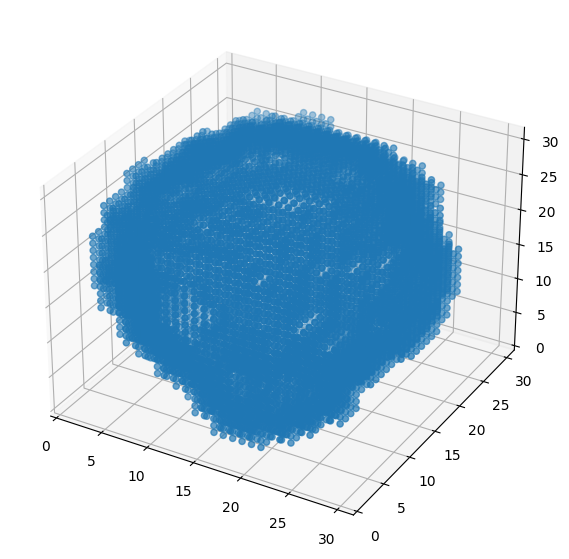

In [33]:
# model_index =5
# o3d.visualization.draw_geometries([voxel_grids[model_index]])
# print("Visualizing the tensor representation:")
# visualize_tensor(voxel_tensors[model_index])


**Visualizing voxel grid**

In [34]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# def visualize_voxel_grid(voxel_grid):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     # Extract voxel grid dimensions
#     x_size, y_size, z_size = voxel_grid.shape

#     # Iterate over each voxel
#     for x in range(1):
#         for y in range(1):
#             for z in range(1):
#                 if voxel_grid[x, y, z] == 1:  # Filled voxel
#                     ax.scatter(x, y, z, color='b')

#     # Set labels and title
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.set_title('Voxel Grid Visualization')

#     plt.show()

# # Example usage
# # voxel_grid = np.random.randint(0, 2, size=(16, 16, 16))  # Random voxel grid for demonstration
# visualize_voxel_grid(voxel_grid)

**PRETRAINED TEXT ENCODER USING T5**

In [35]:
import torch
import torch.nn as nn
import transformers
from transformers import T5ForConditionalGeneration, AutoTokenizer

In [93]:

class TextEncoder(nn.Module):
    def __init__(self, model_name="t5-large"):  # Choose a suitable T5 model size
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.transformer = T5ForConditionalGeneration.from_pretrained(model_name)

    def forward(self, text_input):
        input = self.tokenizer(text_input, return_tensors="pt")  # Tokenize input
        start_token_id = self.tokenizer.unk_token_id   # Or the correct start token for your model.
        decoder_input_ids = torch.tensor([[start_token_id]])
        input['decoder_input_ids'] = decoder_input_ids
        # print(input)
        outputs = self.transformer(**input)  # T5 model expects specific keyword arguments

        # Select appropriate representation
        # hidden_states = outputs.last_hidden_state  # Option 1: Last hidden state
        # Or potentially the encoder outputs if you need it for rephrasing later
        hidden_states = outputs.encoder_last_hidden_state

        # Simple mean pooling
        latent_representation = hidden_states.mean(dim=1)

        return latent_representation

In [37]:
sample_descriptions = ["A modern living room A minimalist bedroom A chair "]
text_encoder = TextEncoder()
for description in sample_descriptions:
    latent_representation = text_encoder(description)
    print(f"Description: {description}")
    print(f"Latent Representation: {latent_representation.shape}") # Check the shape
    print("--------------")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

{'input_ids': tensor([[   71,   941,   840,   562,    71, 19487,  2923,    71,  3533,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'decoder_input_ids': tensor([[2]])}
Description: A modern living room A minimalist bedroom A chair 
Latent Representation: torch.Size([1, 1024])
--------------


**GENERATOR AND DISCRIMINATOR MODELS**

In [103]:
import torch.nn as nn

# Generator architecture
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4 * 4),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose3d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4, 4)  # Reshape to 3D volume
        x = self.deconv(x)
        return x


In [39]:
latent_dim = 1024  # Size of latent representation
generator = Generator(latent_dim)
# Assuming latent_representation is your torch tensor of shape (1, 1024)
with torch.no_grad():
    generated_volume = generator(latent_representation)


In [40]:
generated_volume.shape

torch.Size([1, 1, 32, 32, 32])

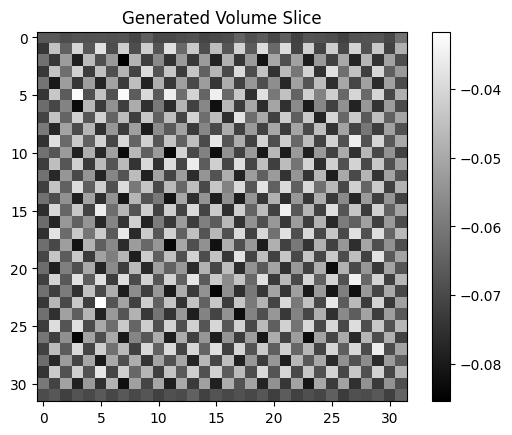

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot a slice of the generated volume
slice_index = 16  # Adjust as needed
volume_slice = generated_volume[0,0, :, :, slice_index]
plt.imshow(volume_slice.cpu().numpy(), cmap='gray')
plt.title('Generated Volume Slice')
plt.colorbar()
plt.show()

In [183]:

# Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 2 * 2 * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 256 * 2 * 2 * 2)  # Flatten
        x = self.fc(x)
        return x


In [195]:
!pip install torchsummary

In [197]:
from torchsummary import summary
# Create an instance of the discriminator model
discriminator = Discriminator()

# Use torchsummary to describe the model
summary(discriminator, (1, 32, 32, 32))  # Input shape: (batch_size, channels, depth, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 16, 16, 16]           4,160
         LeakyReLU-2       [-1, 64, 16, 16, 16]               0
            Conv3d-3         [-1, 128, 8, 8, 8]         524,416
         LeakyReLU-4         [-1, 128, 8, 8, 8]               0
            Conv3d-5         [-1, 256, 4, 4, 4]       2,097,408
         LeakyReLU-6         [-1, 256, 4, 4, 4]               0
            Linear-7                    [-1, 1]           2,049
           Sigmoid-8                    [-1, 1]               0
Total params: 2,628,033
Trainable params: 2,628,033
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 5.25
Params size (MB): 10.03
Estimated Total Size (MB): 15.40
----------------------------------------------------------------


In [203]:
generator =Generator(1024)
summary(generator, (1,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 32768]      33,587,200
              ReLU-2             [-1, 1, 32768]               0
   ConvTranspose3d-3         [-1, 256, 8, 8, 8]       8,388,864
              ReLU-4         [-1, 256, 8, 8, 8]               0
   ConvTranspose3d-5      [-1, 128, 16, 16, 16]       2,097,280
              ReLU-6      [-1, 128, 16, 16, 16]               0
   ConvTranspose3d-7        [-1, 1, 32, 32, 32]           8,193
           Sigmoid-8        [-1, 1, 32, 32, 32]               0
Total params: 44,081,537
Trainable params: 44,081,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 11.00
Params size (MB): 168.16
Estimated Total Size (MB): 179.16
----------------------------------------------------------------


In [182]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         # Define convolutional layers
#         self.conv1 = nn.Conv3d(32, 64, kernel_size=4, stride=2, padding=1)
#         self.conv2 = nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1)
#         # Add more convolutional layers as needed

#         # Define linear layers
#         self.fc1 = nn.Linear(128 * 4 * 4 * 4, 1)  # Adjust the input size based on the output shape of the last convolutional layer

#     def forward(self, x):
#         # Apply convolutional layers with activation functions
#         x = nn.functional.relu(self.conv1(x))
#         x = nn.functional.relu(self.conv2(x))
#         # Add more convolutional layers as needed

#         # Flatten the output tensor
#         x = x.view(-1, 128 * 4 * 4 * 4)  # Adjust the input size based on the output shape of the last convolutional layer

#         # Apply linear layer
#         x = self.fc1(x)
#         return x

In [184]:
# Assuming real_input and fake_input are torch tensors representing real and fake input volumes
# Real input volumes are sampled from the dataset
# Fake input volumes are generated by the generator
with torch.no_grad():
    fake_input = generator(latent_representation)


In [186]:
# # Instantiate the discriminator
# discriminator = Discriminator()
# # Assuming discriminator is your discriminator model

# real_output = discriminator(voxel_tensor_with_batch)
# fake_output = discriminator(fake_input)


In [46]:
import torch.nn.functional as F

# Assuming criterion is your loss function (e.g., binary cross-entropy)
# Assuming labels for real input are 1 and for fake input are 0
real_labels = torch.ones_like(real_output)
fake_labels = torch.zeros_like(fake_output)

real_loss = F.binary_cross_entropy_with_logits(real_output, real_labels)
fake_loss = F.binary_cross_entropy_with_logits(fake_output, fake_labels)

# Total discriminator loss
discriminator_loss = real_loss + fake_loss


In [171]:
import torch.optim as optim

# Assuming discriminator is your discriminator model
# You need to specify the parameters that you want to optimize (e.g., discriminator.parameters())
# You can adjust the learning rate and other hyperparameters as needed
optimizer = optim.Adam(discriminator.parameters(), lr=0.001)


In [49]:
# Assuming optimizer is your optimizer (e.g., Adam)
optimizer.zero_grad()
discriminator_loss.backward()
optimizer.step()

In [153]:
voxel_tensors[0].shape

torch.Size([32, 32, 32])

**Model Training**

In [187]:
voxel_tensors  # List of voxel tensors
text_descriptions = df['description'].tolist()   # List of annotations corresponding to voxel tensors
# text_encoder = TextEncoder()

In [129]:
# import torch
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader

# class CustomDataset(Dataset):
#     def __init__(self, text_data, voxelgrid_data, text_encoder, batch_size):
#         self.text_data = text_data
#         self.voxelgrid_data = voxelgrid_data
#         self.text_encoder = text_encoder
#         self.batch_size = batch_size

#     def __len__(self):
#         return len(self.text_data) // self.batch_size

#     def __iter__(self):
#         for i in range(0, len(self.text_data), self.batch_size):
#             # text_batch = self.text_data[i:i+self.batch_size]
#             # voxelgrid_batch = self.voxelgrid_data[i:i+self.batch_size]

# # real_input = voxel_tensors[5]
# # voxel_tensor_with_batch = real_input.unsqueeze(0)

#             # Encode text descriptions to latent representations
#             encoded_text = [self.text_encoder(text) for text in self.text_data]
#             voxel_tensor = [voxel_grid.unsqueeze(0) for voxel_grid in self.voxelgrid_data]
#             print('hoooooooooo',voxel_tensor_with_batch)

#             yield encoded_text, voxel_tensor


In [188]:

# Instantiate the text encoder and other necessary components
text_encoder = TextEncoder()
batch_size = 32  # Define your batch size
num_epochs = 10  # Define the number of epochs
learning_rate = 0.0002  # Define the learning rate
# print(len(text_descriptions), len(voxel_tensors))
# Define the DataLoader
# dataset = CustomDataset(text_descriptions, voxel_tensors, text_encoder, batch_size)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# data_loader.__getitem__(2)

In [189]:

# Instantiate the discriminator
discriminator = Discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()


In [190]:
voxel_tensors[0].shape

torch.Size([32, 32, 32])

In [198]:
train_loader = torch.utils.data.DataLoader(voxel_tensors, batch_size=1, shuffle=True)

In [ ]:
# x = torch.zeros(1, 1024, dtype=torch.float64)
# Training loop
latent_dim = 1024
for epoch in range(num_epochs):
    # dataset = CustomDataset(text_descriptions, voxel_tensors, text_encoder, batch_size)
    for voxelgrid_tensor in train_loader:
      # Generate noise samples
        latent_representation = torch.randn(batch_size, latent_dim)
        # print(len(text_batch), len(voxelgrid_batch))

        # print("Latent batch shape:", latent_representation[i], voxelgrid_tensor[i])

        with torch.no_grad():
            # Generate fake input
            fake_input = generator(latent_representation)
        # print(text_batch[0].shape)

        real_input = voxelgrid_tensor
        # print(real_input.shape)
        # voxel_tensor_with_batch = [real.squeeze(0) for real in voxelgrid_batch]

        # Compute real and fake outputs
        if real_input.shape ==  torch.Size([32, 32, 32]):
            real_output = discriminator(real_input)
            fake_output = discriminator(fake_input)

            # Compute loss
            real_labels = torch.ones_like(real_output)
            fake_labels = torch.zeros_like(fake_output)
            real_loss = criterion(real_output, real_labels)
            fake_loss = criterion(fake_output, fake_labels)
            discriminator_loss = real_loss + fake_loss

            # Backpropagation and optimization
            discriminator_optimizer.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()

        # Training generator (not included in the provided code snippet)
        # You would also need to train the generator using a similar process
    # Print training progress (optional)
            print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {discriminator_loss.item()}")


Epoch [1/10], Discriminator Loss: 1.4483240842819214
Epoch [2/10], Discriminator Loss: 1.4483240842819214
Epoch [3/10], Discriminator Loss: 1.4483240842819214


https://realpython.com/generative-adversarial-networks/

In [ ]:

# After training, you can save your models if needed
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# class CustomDataset(Dataset):
#     def __init__(self, voxel_tensors, annotations):
#         self.voxel_tensors = voxel_tensors
#         self.annotations = annotations

#     def __len__(self):
#         return len(self.voxel_tensors)

#     def __getitem__(self, idx):
#         voxel_tensor = self.voxel_tensors[idx]
#         annotation = self.annotations[idx]

#         # Assuming you have a function to preprocess annotations and voxel tensors
#         preprocessed_annotation = preprocess_annotation(annotation)
#         preprocessed_voxel_tensor = preprocess_voxel_tensor(voxel_tensor)

#         return preprocessed_voxel_tensor, preprocessed_annotation


In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# class CustomDataset(Dataset):
#     def __init__(self, text_data, voxelgrid_data, text_encoder, batch_size):
#         self.text_data = text_data
#         self.voxelgrid_data = voxelgrid_data
#         self.text_encoder = text_encoder
#         self.batch_size = batch_size

#     def __len__(self):
#         return len(self.text_data) // self.batch_size

#     def __iter__(self):
#         for i in range(0, len(self.text_data), self.batch_size):
#             text_batch = self.text_data[i:i+self.batch_size]
#             voxelgrid_batch = self.voxelgrid_data[i:i+self.batch_size]

#             # Encode text descriptions to latent representations
#             encoded_text_batch = [self.text_encoder(text) for text in text_batch]

#             yield encoded_text_batch, voxelgrid_batch

In [ ]:

# # Assuming you have lists of voxel tensors and annotations
# voxel_tensors  # List of voxel tensors
# annotations = df['description'].tolist()   # List of annotations corresponding to voxel tensors
# text_encoder = TextEncoder()
# batch_size = 32
# # Create an instance of your custom dataset class
# custom_dataset = CustomDataset( annotations, voxel_tensors, text_encoder, batch_size)

# # Create a DataLoader to load batches of data from the dataset

# shuffle = True  # Whether to shuffle the data between epochs
# data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle)


In [ ]:
import tensorflow as tf

In [ ]:
# # Initialize models and optimizers
# latent_dim = 1024
# generator = Generator(latent_dim)
# discriminator = Discriminator()
# generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
# discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

# # Define loss functions
# cross_entropy = tf.keras.losses.BinaryCrossentropy()
# num_epochs = 100
# batch_size = 32

# # Training loop
# for epoch in range(num_epochs):
#     for text_batch, voxelgrid_batch in data_loader:
#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             # Generate fake voxel grids
#             generated_voxelgrids = generator(text_batch, training=True)

#             # Discriminator loss
#             real_output = discriminator(voxelgrid_batch, training=True)
#             fake_output = discriminator(generated_voxelgrids, training=True)
#             disc_real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#             disc_fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#             disc_loss = disc_real_loss + disc_fake_loss

#             # Generator loss
#             gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

#         # Compute gradients and update parameters
#         gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#         gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
#         generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
# # Initialize models and optimizers
# latent_dim = 1024
# generator = Generator(latent_dim)
# discriminator = Discriminator()
# generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
# discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# # Define loss functions
# criterion = nn.BCELoss()
# num_epochs = 100
# batch_size = 32

# # Training loop
# for epoch in range(num_epochs):
#     for real_input in data_loader:
#         # Train discriminator
#         discriminator_optimizer.zero_grad()
#         real_output = discriminator(real_input)
#         fake_input = generator.sample_fake_data(batch_size)
#         fake_output = discriminator(fake_input)
#         real_loss = criterion(real_output, torch.ones_like(real_output))
#         fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
#         discriminator_loss = real_loss + fake_loss
#         discriminator_loss.backward()
#         discriminator_optimizer.step()

#         # Train generator
#         generator_optimizer.zero_grad()
#         fake_input = generator.sample_fake_data(batch_size)
#         fake_output = discriminator(fake_input)
#         generator_loss = criterion(fake_output, torch.ones_like(fake_output))
#         generator_loss.backward()
#         generator_optimizer.step()



Certainly! Below is a Python code example demonstrating how to visualize results and calculate metrics for evaluating a Generative Adversarial Network (GAN). This example assumes you're working with image data and focuses on visualizing generated samples and calculating the Frechet Inception Distance (FID) as a metric.

### ***Data Preparation: Preprocess your dataset to pair each text description with its corresponding voxel grid representation of the 3D model.***
Model Architecture:
Text Encoder: Convert text descriptions into a fixed-size vector representation, such as [1,1024].
Generator: Takes the output of the text encoder and generates voxel grids of size (16,16,16).
Discriminator: Takes voxel grids of size (16,16,16) as input and predicts whether they are real or generated.
Connecting the Components:
Pass the text description through the text encoder to get the fixed-size vector representation.
Feed this vector representation into the generator to produce a voxel grid.
Pass both the real voxel grids (from the dataset) and generated voxel grids through the discriminator.
Loss Functions:
Generator Loss: Use a combination of traditional image generation loss functions such as pixel-wise mean squared error (MSE) or binary cross-entropy loss.
Discriminator Loss: Train the discriminator to distinguish between real and generated voxel grids using binary cross-entropy loss.
Training:
Alternately train the generator and discriminator in a GAN-like setup:
Train the discriminator to correctly classify real and generated voxel grids.
Train the generator to fool the discriminator by generating voxel grids that the discriminator classifies as real.
Use techniques like mini-batch discrimination and label smoothing to improve stability.
Evaluation:
Assess the quality of generated 3D models using evaluation metrics such as Frechet Inception Distance (FID), Structural Similarity Index (SSIM), or human evaluation.
Fine-tuning and Iteration:
Fine-tune your model and experiment with different architectures, hyperparameters, and training strategies to improve performance.

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers

# # Define the Text Encoder
# text_encoder = models.Sequential([
#     layers.Embedding(vocabulary_size, embedding_size, input_length=max_text_length),
#     layers.LSTM(512)  # Example LSTM layer, adjust units as needed
# ])

# # Define the Generator
# generator = models.Sequential([
#     layers.InputLayer(input_shape=(latent_dim + embedding_size,)),  # Concatenated input of latent dim and text embedding
#     layers.Dense(4 * 4 * 4 * 128, activation='relu'),
#     layers.Reshape((4, 4, 4, 128)),
#     layers.Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'),
#     layers.Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'),
#     layers.Conv3DTranspose(1, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='sigmoid')
# ])

# # Define the Discriminator
# discriminator = models.Sequential([
#     layers.InputLayer(input_shape=(16, 16, 16, 1)),
#     layers.Conv3D(32, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'),
#     layers.Conv3D(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'),
#     layers.Conv3D(128, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'),
#     layers.Flatten(),
#     layers.Dense(1, activation='sigmoid')
# ])

# # Define the combined model for training the generator
# text_input = tf.keras.Input(shape=(max_text_length,))
# latent_input = tf.keras.Input(shape=(latent_dim,))
# text_embedding = text_encoder(text_input)
# combined_input = layers.concatenate([latent_input, text_embedding])
# generated_voxelgrid = generator(combined_input)
# discriminator_output = discriminator(generated_voxelgrid)

# combined_model = models.Model([text_input, latent_input], discriminator_output)

# # Define separate optimizers for generator and discriminator
# generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
# discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# # Define loss function for the discriminator
# def discriminator_loss(real_output, generated_output):
#     real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
#     generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_output), generated_output)
#     return real_loss + generated_loss

# # Define loss function for the generator
# def generator_loss(generated_output):
#     return tf.keras.losses.binary_crossentropy(tf.ones_like(generated_output), generated_output)

# # Training loop
# for epoch in range(num_epochs):
#     for text_batch, voxelgrid_batch in dataset:
#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             text_embedding = text_encoder(text_batch, training=True)
#             noise = tf.random.normal((text_embedding.shape[0], latent_dim))
#             combined_input = layers.concatenate([noise, text_embedding])
#             generated_voxelgrid = generator(combined_input, training=True)

#             real_output = discriminator(voxelgrid_batch, training=True)
#             generated_output = discriminator(generated_voxelgrid, training=True)

#             gen_loss = generator_loss(generated_output)
#             disc_loss = discriminator_loss(real_output, generated_output)

#         gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#         gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#         generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



Increasing the size of the voxel grid to (128, 128, 128) will have several implications:

Increased Memory Usage: Larger voxel grids require more memory to store both during training and inference. This means you'll need more RAM or VRAM, depending on whether you're training on CPU or GPU, respectively.
Higher Computational Complexity: With a larger grid, the number of voxels to process increases significantly. This leads to higher computational complexity for both the generator and discriminator networks, resulting in longer training times per iteration.
Architecture Adjustments: The architectures of the generator and discriminator networks will need to be adjusted to accommodate the larger input and output dimensions. For example, you may need to increase the number of layers, filters, or neurons in the networks to handle the increased complexity.
Training Stability: Larger voxel grids may lead to training instability, especially in the early stages of training. Techniques such as gradient clipping, batch normalization, and spectral normalization may be necessary to stabilize training.
Data Requirements: Generating high-resolution voxel grids requires more detailed and diverse training data to capture the complexity of real-world objects accurately. Ensure that your dataset is large and varied enough to support training with the larger voxel grid size effectively.
Evaluation Metrics: When evaluating the quality of generated models, consider using metrics that account for the increased resolution, such as voxel-based metrics or perceptual metrics like Frechet Inception Distance (FID) adapted for 3D data.
Hardware Limitations: Finally, ensure that your hardware can handle the increased memory and computational demands of training with larger voxel grids. High-performance GPUs with ample VRAM are typically required for training deep learning models with large inputs.
Overall, while increasing the voxel grid size to (128, 128, 128) may lead to higher-quality 3D model generation, it also comes with challenges related to memory usage, computational complexity, and training stability. Balancing these factors is essential for successful training and generation of high-fidelity 3D models.

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers

# # Define the Text Encoder
# text_encoder = models.Sequential([
#     layers.Embedding(vocabulary_size, embedding_size, input_length=max_text_length),
#     layers.LSTM(512)  # Example LSTM layer, adjust units as needed
# ])

# # Define the Generator
# generator = models.Sequential([
#     layers.InputLayer(input_shape=(latent_dim + embedding_size,)),  # Concatenated input of latent dim and text embedding
#     layers.Dense(4 * 4 * 4 * 256, activation='relu'),
#     layers.Reshape((4, 4, 4, 256)),
#     layers.Conv3DTranspose(128, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'),
#     layers.Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'),
#     layers.Conv3DTranspose(1, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='sigmoid')#[0,1]
#     # tanh for range [-1,1] output voxelgrid
# ])

# # Define the Discriminator
# discriminator = models.Sequential([
#     layers.InputLayer(input_shape=(128, 128, 128, 1)),
#     layers.Conv3D(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'),
#     layers.Conv3D(128, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'),
#     layers.Conv3D(256, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'),
#     layers.Flatten(),
#     layers.Dense(1, activation='sigmoid')
# ])

# # Define the combined model for training the generator
# text_input = tf.keras.Input(shape=(max_text_length,))
# latent_input = tf.keras.Input(shape=(latent_dim,))
# text_embedding = text_encoder(text_input)
# combined_input = layers.concatenate([latent_input, text_embedding])
# generated_voxelgrid = generator(combined_input)
# discriminator_output = discriminator(generated_voxelgrid)

# combined_model = models.Model([text_input, latent_input], discriminator_output)

# # Define separate optimizers for generator and discriminator
# generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
# discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# # Define loss function for the discriminator
# def discriminator_loss(real_output, generated_output):
#     real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
#     generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_output), generated_output)
#     return real_loss + generated_loss

# # Define loss function for the generator
# def generator_loss(generated_output):
#     return tf.keras.losses.binary_crossentropy(tf.ones_like(generated_output), generated_output)

# # Training loop
# for epoch in range(num_epochs):
#     for text_batch, voxelgrid_batch in dataset:
#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             text_embedding = text_encoder(text_batch, training=True)
#             noise = tf.random.normal((text_embedding.shape[0], latent_dim))
#             combined_input = layers.concatenate([noise, text_embedding])
#             generated_voxelgrid = generator(combined_input, training=True)

#             real_output = discriminator(voxelgrid_batch, training=True)
#             generated_output = discriminator(generated_voxelgrid, training=True)

#             gen_loss = generator_loss(generated_output)
#             disc_loss = discriminator_loss(real_output, generated_output)

#         gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#         gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#         generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
